# ADS-508 Project Notebook

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import boto3
import sagemaker
import csv
import pandas as pd

In [3]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()
region = boto3.Session().region_name

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

## Import
### Importing Data from S3 Bucket

In [4]:
!aws s3 cp --recursive s3://aurelia-resort-data/ ./data/

download: s3://aurelia-resort-data/airbnb/neighbourhoods.csv to data/airbnb/neighbourhoods.csv
download: s3://aurelia-resort-data/income/disp_income.csv to data/income/disp_income.csv
download: s3://aurelia-resort-data/airbnb/listings.csv to data/airbnb/listings.csv
download: s3://aurelia-resort-data/travel/airline_2019.csv to data/travel/airline_2019.csv
download: s3://aurelia-resort-data/travel/airline_2017.csv to data/travel/airline_2017.csv
download: s3://aurelia-resort-data/travel/airline_2016.csv to data/travel/airline_2016.csv
download: s3://aurelia-resort-data/travel/airline_2018.csv to data/travel/airline_2018.csv
download: s3://aurelia-resort-data/airbnb/reviews.csv to data/airbnb/reviews.csv
download: s3://aurelia-resort-data/travel/airline_2021.csv to data/travel/airline_2021.csv
download: s3://aurelia-resort-data/travel/airline_2022.csv to data/travel/airline_2022.csv
download: s3://aurelia-resort-data/travel/airline_data_archived.csv to data/travel/airline_data_archived.c

### Ingesting Data via Pandas

In [5]:
airline = pd.concat(
    map(pd.read_csv, ["./data/travel/airline_2022.csv", "./data/travel/airline_2021.csv",
                     "./data/travel/airline_2020.csv", "./data/travel/airline_2019.csv",
                     "./data/travel/airline_2018.csv", "./data/travel/airline_2017.csv", 
                     "./data/travel/airline_2016.csv"]),
    ignore_index=True)

tripsurvey = pd.read_csv("./data/travel/trip_data2.csv")

## Relevant Data Filtering

In [14]:
## Filter data to where DC is destination city

airline = airline[airline["DEST_CITY_NAME"].str.contains("DC")]

## Filter data to where passengers > 0

airline = airline[airline["PASSENGERS"]>0]


In [15]:
airline.shape

(36142, 12)

### Missing Data

In [20]:
print(f'\nMissing Data:\n{airline.isnull().sum()}')

print('\nTotal Missing Data:', airline.isnull().sum().sum())


Missing Data:
PASSENGERS          0
ORIGIN_CITY_NAME    0
ORIGIN_STATE_NM     0
ORIGIN_WAC          0
DEST                0
DEST_CITY_NAME      0
DEST_STATE_NM       0
YEAR                0
QUARTER             0
MONTH               0
DISTANCE_GROUP      0
CLASS               0
dtype: int64

Total Missing Data: 0


In [21]:
print(f'\nMissing Data:\n{tripsurvey.isnull().sum()}')

print('\nTotal Missing Data:', tripsurvey.isnull().sum().sum())


Missing Data:
Level                                0
Date                                 0
State FIPS                          42
State Postal Code                   42
County FIPS                       2184
County Name                       2184
Population Staying at Home         502
Population Not Staying at Home     502
Number of Trips                    502
Number of Trips <1                 502
Number of Trips 1-3                502
Number of Trips 3-5                502
Number of Trips 5-10               502
Number of Trips 10-25              502
Number of Trips 25-50              502
Number of Trips 50-100             502
Number of Trips 100-250            502
Number of Trips 250-500            502
Number of Trips >=500              502
dtype: int64

Total Missing Data: 10978


## Pre-Processing

### Feature Construction: Create Date Columns

In [22]:
#Airline has year and month, needs date

airline['Date'] = pd.to_datetime(airline[['YEAR', 'MONTH']].assign(DAY=1))

In [23]:
#Trip survey has month, needs year and date to be formatted as date

tripsurvey['Year'] = tripsurvey['Date'].str.split("/").str[0]

tripsurvey['Month'] = tripsurvey['Date'].str.split("/").str[1]

tripsurvey['Date'] = pd.to_datetime(tripsurvey[['Year', 'Month']].assign(DAY=1))

### Feature Construction: % of People Who Traveled

In [24]:
tripsurvey['PercentofAmericanswhoTraveled'] = (tripsurvey['Population Not Staying at Home']/(tripsurvey['Population Not Staying at Home']+tripsurvey['Population Staying at Home']))*100

### Group Data by Year and Month

In [25]:
#Group number of flights over time from airline data

airline_grouped_flights = airline.groupby(['Date'], as_index=False)['YEAR'].count()
airline_grouped_flights = airline_grouped_flights.rename(columns={"YEAR": "TotalAirlineTripstoDC"})
airline_grouped_flights.head()

,Date,TotalAirlineTripstoDC
0,2016-01-01,428
1,2016-02-01,421
2,2016-03-01,420
3,2016-04-01,441
4,2016-05-01,427


In [27]:
#Group total passengers over time from airline data

airline_grouped_passengers = airline.groupby(['Date'], as_index=False)['PASSENGERS'].sum()
airline_grouped_passengers = airline_grouped_passengers.rename(columns={"PASSENGERS": "TotalAirlinePassengerstoDC"})
airline_grouped_passengers.head()

,Date,TotalAirlinePassengerstoDC
0,2016-01-01,1208852.0
1,2016-02-01,1228611.0
2,2016-03-01,1560148.0
3,2016-04-01,1562835.0
4,2016-05-01,1683873.0


In [28]:
#Group population traveling from survey data

tripsurvey_grouped_travelers = tripsurvey.groupby(['Date'], as_index=False)['Population Not Staying at Home'].sum()
tripsurvey_grouped_travelers = tripsurvey_grouped_travelers.rename(columns={"Population Not Staying at Home": "TotalAmericanTravelers"})
tripsurvey_grouped_travelers.head()

,Date,TotalAmericanTravelers
0,2019-01-01,7.915365e+08
1,2019-02-01,7.945863e+08
2,2019-03-01,7.911408e+08
3,2019-04-01,7.880608e+08
4,2019-05-01,7.942675e+08


In [29]:
#Group population traveling from survey data

tripsurvey_grouped_travelerperc = tripsurvey.groupby(['Date'], as_index=False)['PercentofAmericanswhoTraveled'].mean()
tripsurvey_grouped_travelerperc.head()

,Date,PercentofAmericanswhoTraveled
0,2019-01-01,81.424641
1,2019-02-01,81.755145
2,2019-03-01,81.773040
3,2019-04-01,81.328957
4,2019-05-01,81.861388


In [30]:
#Group total number of trips from survey data

tripsurvey_grouped_trips_sum = tripsurvey.groupby(['Date'], as_index=False)['Number of Trips'].sum()
tripsurvey_grouped_trips_sum = tripsurvey_grouped_trips_sum.rename(columns={"Number of Trips": "TotalTripsbyAmericans"})
tripsurvey_grouped_trips_sum.head()

,Date,TotalTripsbyAmericans
0,2019-01-01,3.411167e+09
1,2019-02-01,3.446040e+09
2,2019-03-01,3.919756e+09
3,2019-04-01,4.340727e+09
4,2019-05-01,4.245221e+09


### Visualize Data over Time

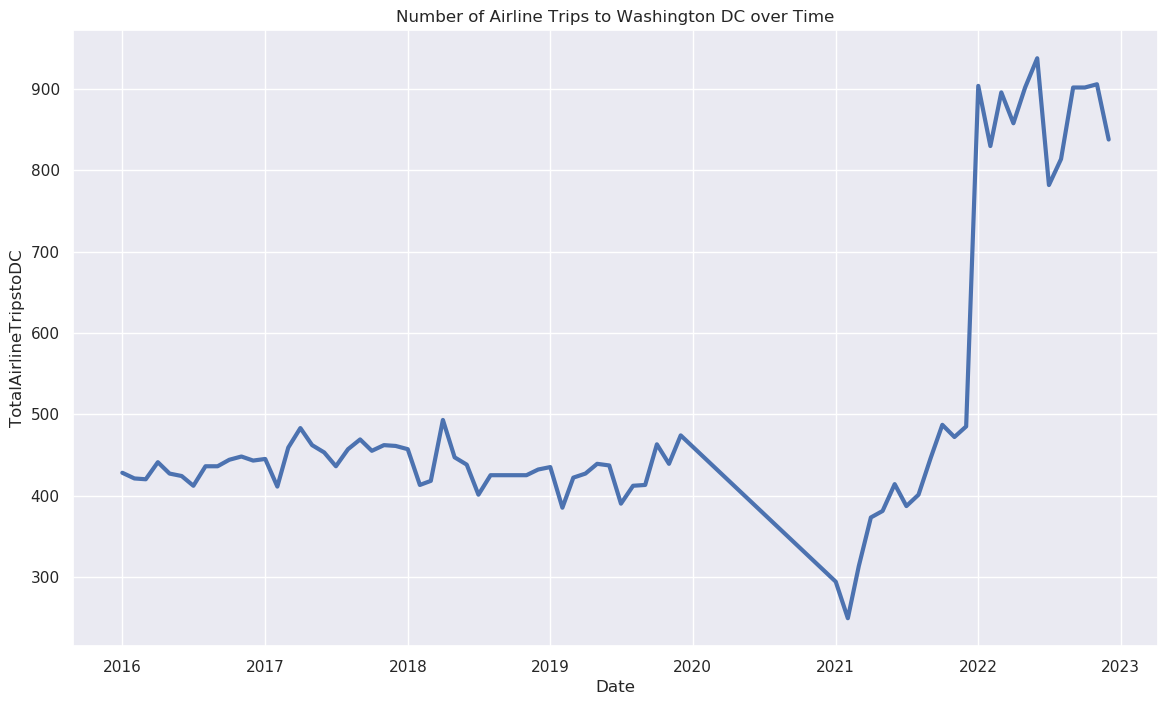

In [32]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(14,8)})

ax = sns.lineplot(data=airline_grouped_flights, x ='Date', y = 'TotalAirlineTripstoDC', palette='viridis', lw=3)
plt.title("Number of Airline Trips to Washington DC over Time")
plt.show()

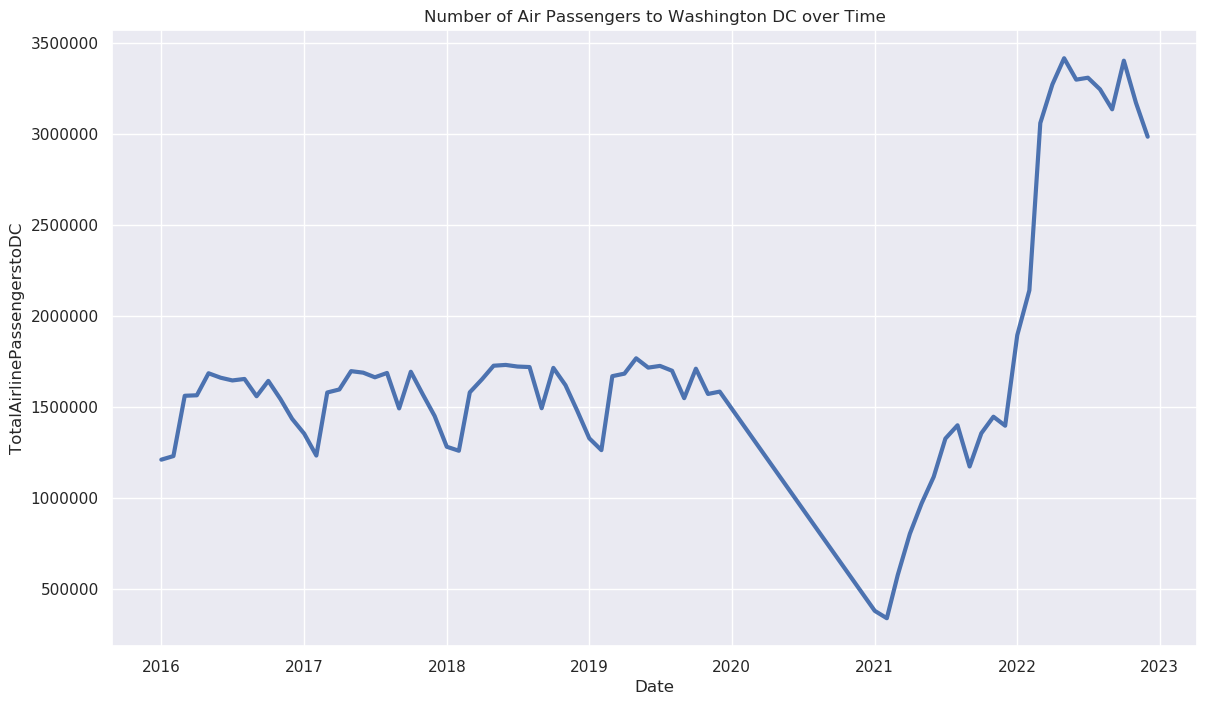

In [33]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(14,8)})

ax = sns.lineplot(data=airline_grouped_passengers, x ='Date', y = 'TotalAirlinePassengerstoDC', palette='viridis', lw=3)
plt.title("Number of Air Passengers to Washington DC over Time")
plt.show()

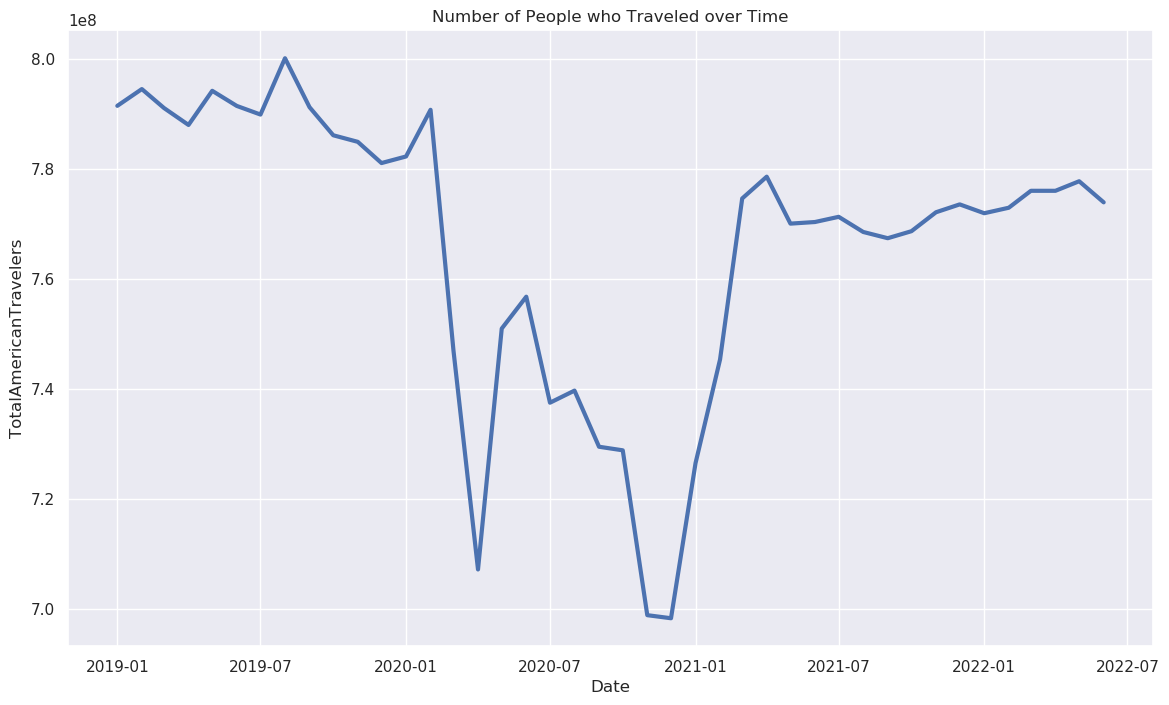

In [34]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(14,8)})

ax = sns.lineplot(data=tripsurvey_grouped_travelers, x ='Date', y = 'TotalAmericanTravelers', palette='viridis', lw=3)
plt.title("Number of People who Traveled over Time")
plt.show()

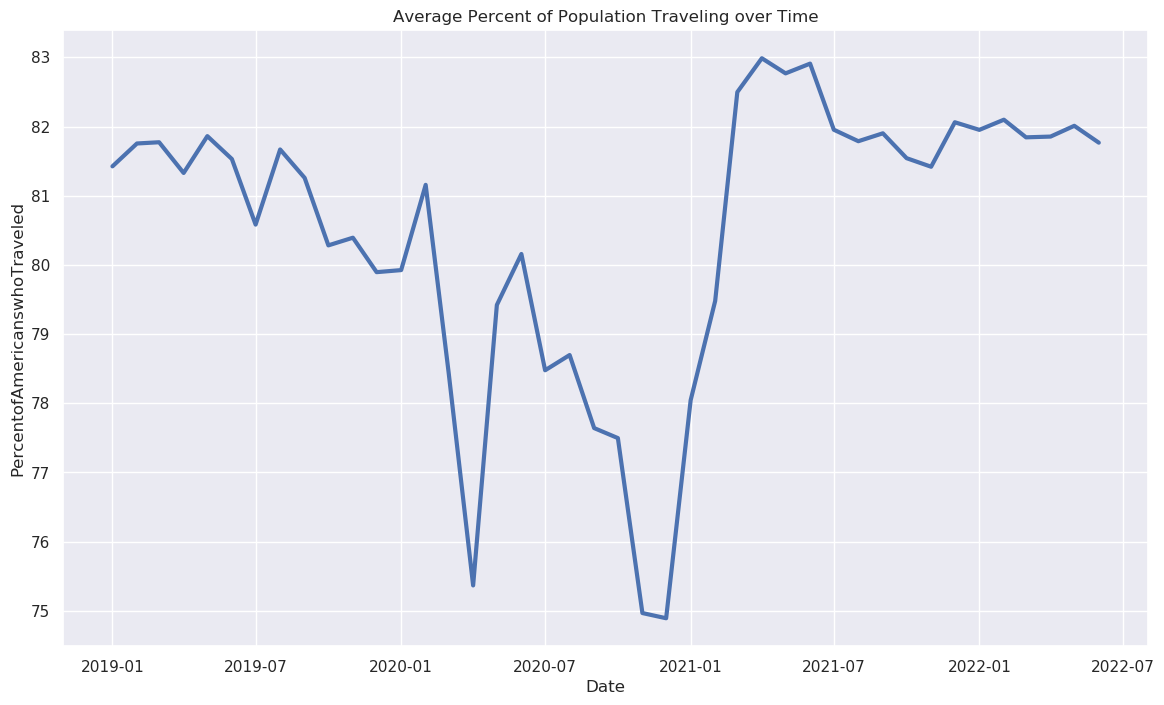

In [35]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(14,8)})

ax = sns.lineplot(data=tripsurvey_grouped_travelerperc, x ='Date', y = 'PercentofAmericanswhoTraveled', palette='viridis', lw=3)
plt.title("Average Percent of Population Traveling over Time")
plt.show()

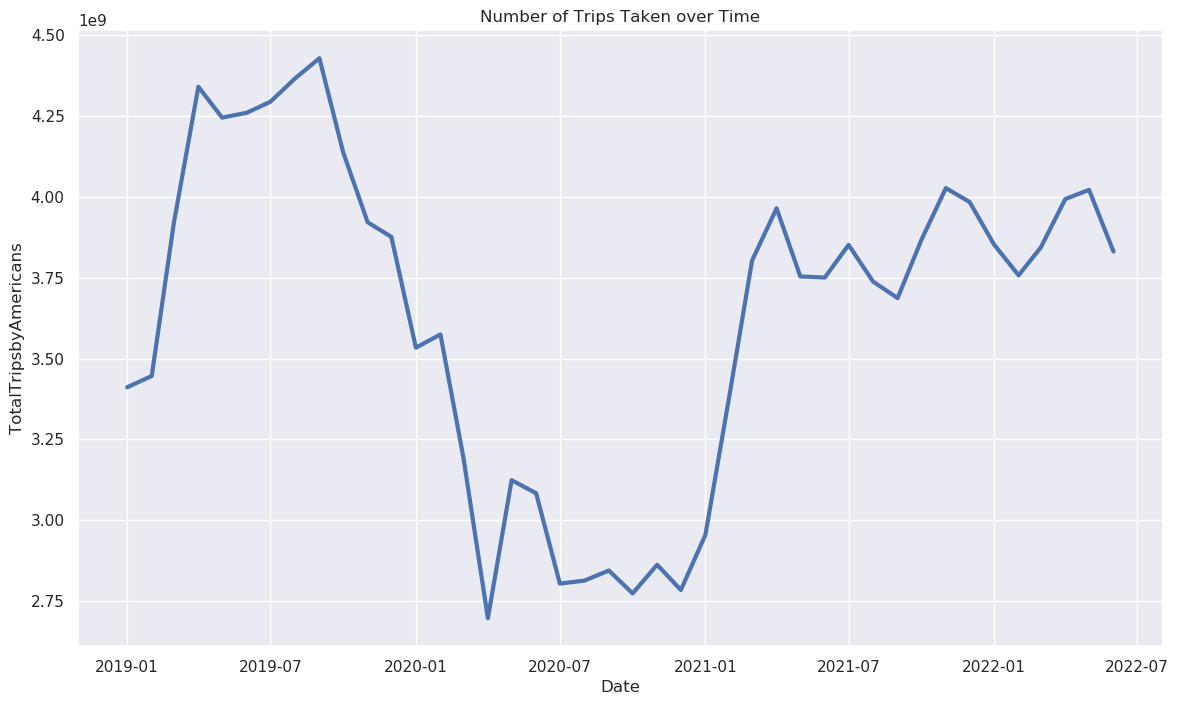

In [36]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(14,8)})

ax = sns.lineplot(data=tripsurvey_grouped_trips_sum, x ='Date', y = 'TotalTripsbyAmericans', palette='viridis', lw=3)
plt.title("Number of Trips Taken over Time")
plt.show()

### Join Data in Singular DF

In [37]:
merge1 = pd.merge(airline_grouped_flights, airline_grouped_passengers, on ='Date')
merge2 = pd.merge(merge1, tripsurvey_grouped_travelers, on ='Date')
merge3 = pd.merge(merge2, tripsurvey_grouped_travelerperc, on = 'Date')
finaldf = pd.merge(merge3, tripsurvey_grouped_trips_sum, on = 'Date')

finaldf.head()

,Date,TotalAirlineTripstoDC,TotalAirlinePassengerstoDC,TotalAmericanTravelers,PercentofAmericanswhoTraveled,TotalTripsbyAmericans
0,2019-01-01,435,1326271.0,7.915365e+08,81.424641,3.411167e+09
1,2019-02-01,385,1261292.0,7.945863e+08,81.755145,3.446040e+09
2,2019-03-01,422,1668002.0,7.911408e+08,81.773040,3.919756e+09
3,2019-04-01,427,1681832.0,7.880608e+08,81.328957,4.340727e+09
4,2019-05-01,439,1766148.0,7.942675e+08,81.861388,4.245221e+09


### Train, Test, Split

In [38]:
test_size = 6

traindf = finaldf[:-test_size]
testdf = finaldf[-test_size:]

## Release Resources

In [ ]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>

In [ ]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}